# Compare Linear and Ridge regressor
The linear and Ridge regressors are implemented by me.
All comparisons will be done using the cleaned, encoded, standardized dataset.

In [140]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import category_encoders as ce

from IPython.display import clear_output
from itables import show

from linearReg import LinearReg
from ridgeReg import RidgeReg

In [1]:
# load dataframe
df = pd.read_csv("dataset.csv", index_col=0)
# fix duplicates track_ids
grouped = df.groupby(by='track_id')
fixed = grouped.agg({"popularity":"min","track_genre":lambda x: ';'.join(x)})
fixed[fixed['track_genre'].str.contains(';')]
df_dropped = df.drop_duplicates(subset=['track_id'])
df_new = df_dropped.set_index('track_id')
df_new['track_genre'] = fixed['track_genre']
df_new['popularity'] = fixed['popularity']

# df_new = df_new.drop('track_id',axis=1)
df["explicit"] = df["explicit"].astype(int)

X = df_new.drop('popularity',axis=1)
y = df_new['popularity']

NameError: name 'pd' is not defined

In [238]:
def runKFold(model,name):
  kfold = RepeatedKFold(random_state=1,n_repeats=1,n_splits=5)
  train_scores = []
  test_scores = []
  for i, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    # encoding categorical features
    enc = ce.TargetEncoder(cols=['artists','track_name','album_name','track_genre'],min_samples_leaf=2,smoothing=0.000001).fit(X_train,y_train)
    X_train = enc.transform(X_train)
    X_test = enc.transform(X_test)
    #show(X_train)
    
    # scale data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
    #show(X_train_scaled)

    # check performance
    model.fit(X_train_scaled,y_train)

    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    # print([(x,y) for (x,y) in zip(y_test,pred)])
    train_score = r2_score(y_train, train_pred)
    test_score = r2_score(y_test, test_pred)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    print((train_score,test_score))
  
  clear_output(wait=False)
  mean_train_score = sum(train_scores)/len(train_scores)
  mean_test_score = sum(test_scores)/len(test_scores)
  print(f"Average {name} R2 train score: {mean_train_score}")
  print(f"Average {name} R2 test score: {mean_test_score}")
  return mean_train_score, mean_test_score

# Linear Regression

In [239]:
runKFold(LinearReg(),'Linear Regression') #(0.9265216002799029, 0.5777387850053584)

(0.7253131154276111, 0.6377727935515868)
(0.7252467678087955, 0.640598883545279)
(0.7242497777915782, 0.6419332421871432)


# Ridge Regression

In [87]:
runKFold(RidgeReg(0.),'Ridge Regression')

Average Ridge Regression R2 train score: 0.7895204043336254
Average Ridge Regression R2 test score: 0.4916904438813375


(0.7895204043336254, 0.4916904438813375)

In [88]:
runKFold(Ridge(alpha=0,solver='cholesky'),'RidgeSk')

Average RidgeSk R2 train score: 0.7895204043336254
Average RidgeSk R2 test score: 0.49169044388133765


(0.7895204043336254, 0.49169044388133765)

In [113]:
scores = []
for alpha in [0,10,100,200,300,400,500,700,1000]:
  scores.append((alpha,runKFold(RidgeReg(alpha),'Ridge Regression')))
print(max(scores,key=lambda v:v[1][1]))

Average Ridge Regression R2 train score: 0.7892148660363617
Average Ridge Regression R2 test score: 0.49173949942086814
(700, (0.7892148660363617, 0.49173949942086814))


[(0, (0.7895204043336254, 0.4916904438813375)), (10, (0.7895203405731132, 0.49169588019353766)), (100, (0.7895140469535663, 0.49173849129376324)), (200, (0.7894950573144156, 0.4917726034604682)), (300, (0.7894635580407176, 0.4917929359817039)), (400, (0.7894196702799839, 0.49179964207305177)), (500, (0.7893635137336378, 0.4917928726265856)), (700, (0.7892148660363617, 0.49173949942086814)), (1000, (0.7889027911873768, 0.49156201811009964))]


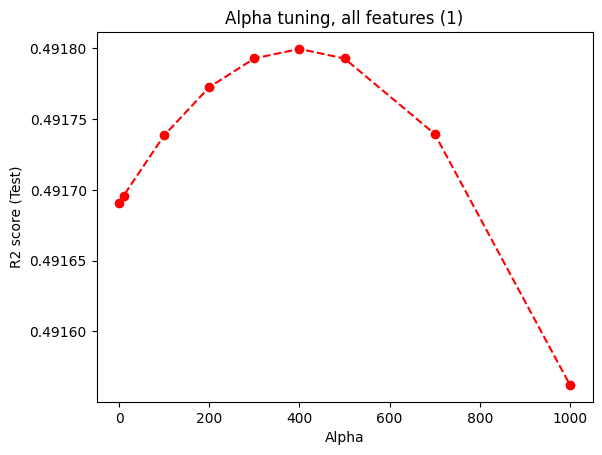

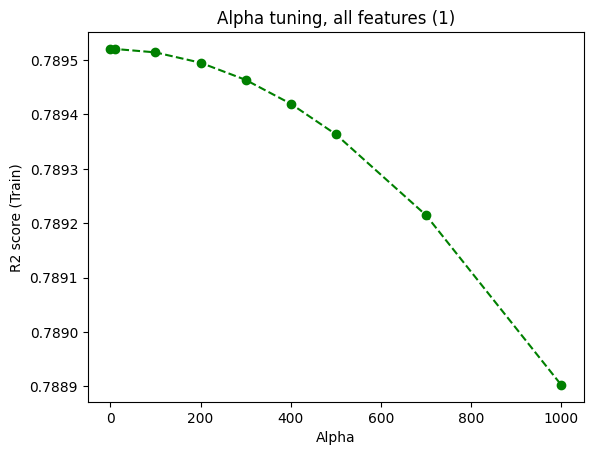

In [139]:
import matplotlib.pyplot as plt
scores = [(0, (0.7895204043336254, 0.4916904438813375)), (10, (0.7895203405731132, 0.49169588019353766)), (100, (0.7895140469535663, 0.49173849129376324)), (200, (0.7894950573144156, 0.4917726034604682)), (300, (0.7894635580407176, 0.4917929359817039)), (400, (0.7894196702799839, 0.49179964207305177)), (500, (0.7893635137336378, 0.4917928726265856)),(700, (0.7892148660363617, 0.49173949942086814)), (1000, (0.7889027911873768, 0.49156201811009964))]
print(scores)
x = [score[0] for score in scores]
y_train = [score[1][0] for score in scores]
y_test = [score[1][1] for score in scores]
#plt.plot(x,y_train)
fig,ax = plt.subplots()
ax.plot(x,y_test,linestyle='--',marker='o',color='red')
ax.set_title("Alpha tuning, all features (1)")
ax.set_ylabel("R2 score (Test)")
ax.set_xlabel("Alpha")
plt.show()
fig,ax = plt.subplots()
ax.plot(x,y_train,linestyle='--',marker='o',color='green')
ax.set_title("Alpha tuning, all features (1)")
ax.set_ylabel("R2 score (Train)")
ax.set_xlabel("Alpha")
plt.show()

In [136]:
scores2 = []
for alpha in range(390,411,2):
  scores2.append((alpha,runKFold(RidgeReg(alpha),'Ridge Regression')))
print(max(scores2,key=lambda v:v[1][1]))

KeyboardInterrupt: 

[(390, (0.7894246131152864, 0.4917995803348978)), (392, (0.7894236343688735, 0.49179960346999957)), (394, (0.7894226507111844, 0.4917996212101665)), (396, (0.7894216621431714, 0.49179963355659845)), (398, (0.7894206686657871, 0.491799640510494)), (400, (0.7894196702799839, 0.49179964207305177)), (402, (0.7894186669867135, 0.49179963824546985)), (404, (0.7894176587869278, 0.491799629028946)), (406, (0.7894166456815785, 0.49179961442467773)), (408, (0.7894156276716165, 0.491799594433862)), (410, (0.7894146047579936, 0.49179956905769556))]


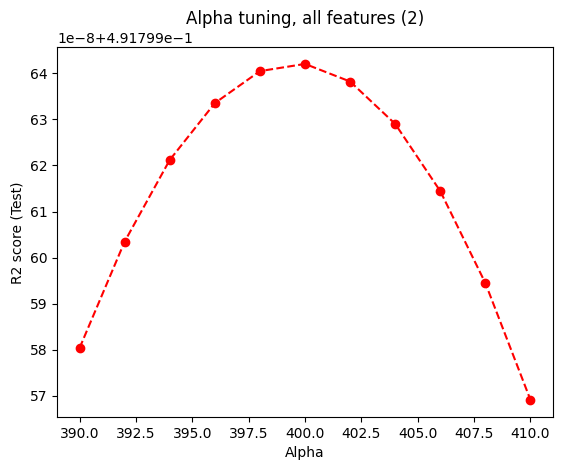

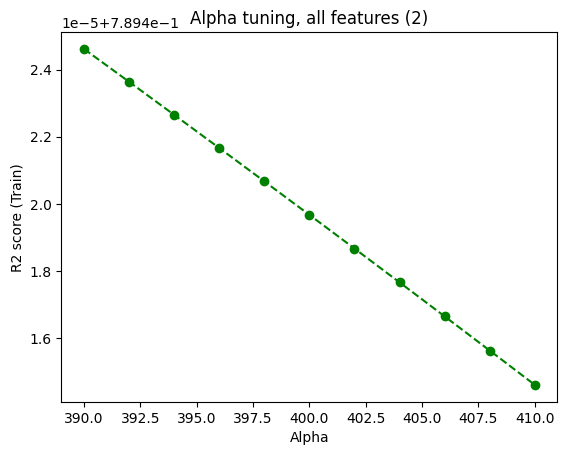

In [138]:
import matplotlib.pyplot as plt
scores2 = [(390, (0.7894246131152864, 0.4917995803348978)), (392, (0.7894236343688735, 0.49179960346999957)), (394, (0.7894226507111844, 0.4917996212101665)), (396, (0.7894216621431714, 0.49179963355659845)), (398, (0.7894206686657871, 0.491799640510494)), (400, (0.7894196702799839, 0.49179964207305177)), (402, (0.7894186669867135, 0.49179963824546985)), (404, (0.7894176587869278, 0.491799629028946)), (406, (0.7894166456815785, 0.49179961442467773)), (408, (0.7894156276716165, 0.491799594433862)), (410, (0.7894146047579936, 0.49179956905769556))]
print(scores2)
x = [score[0] for score in scores2]
y_train = [score[1][0] for score in scores2]
y_test = [score[1][1] for score in scores2]
#plt.plot(x,y_train)
fig,ax = plt.subplots()
ax.plot(x,y_test,linestyle='--',marker='o',color='red')
ax.set_title("Alpha tuning, all features (2)")
ax.set_ylabel("R2 score (Test)")
ax.set_xlabel("Alpha")
plt.show()
fig,ax = plt.subplots()
ax.plot(x,y_train,linestyle='--',marker='o',color='green')
ax.set_title("Alpha tuning, all features (2)")
ax.set_ylabel("R2 score (Train)")
ax.set_xlabel("Alpha")
plt.show()